# Single pixel sampler 

This notebook contains a Marcov Chain Monte Carlo (MCMC) sampler and a Gibbs sampler for doing component separation for a singel pixel. By sampling over only one pixel we can easely do tens of thousands of iterations quickly. Thus we aim to give an intuitive understanding of how Commander3 works without having to go through all the Commander code in details. To see the full details on Commander3, please see the [main BeyondPlanck paper](https://arxiv.org/pdf/2011.05609.pdf) and the acompanying papers, as well as the [Commander3 code itself](https://github.com/Cosmoglobe/Commander).

An overview of the three sessions are as follows:
1. The sky model
2. Markov chain Monte Carlo (MCMC) sampling and how to understand probability distributions. Priors
3. Gibbs sampling: banana shape curves

# 1: Sky model
First we will introduce the data model for the polarized sky containing CMB (Cosmic Microwave Backround), synchrotron and thermal dust. 

### CMB
For the CMB radiation we have 
$$s_{\mathrm{CMB}} = a_{\mathrm{CMB}} \frac{x^2e^{x}}{\left(e^{x}-1\right)^2}$$
where $a_{\mathrm{CMB}}$ is the strength (amplitude) of the signal and the rest is a converstion factor between Rayleigh Jeans units and CMB units where  $x=h\nu/kT_0$.

### Synchrotron
The synchrotron radiation dominates the lower frequency bands. We use a power law model given by
$$s_{\mathrm{s}} = a_{\mathrm{s}} \left(\frac{\nu}{\nu_{0,\mathrm{s}}} \right)^{\beta_{\mathrm{s}}+ C \log\left(\frac{\nu}{\nu_{0,\mathrm{s}}}\right)}$$
where $a_{\mathrm{s}}$ is the strength of the signal at the reference frequency $\nu_{0,\mathrm{s}}$, $\beta_{\mathrm{s}}$ is the spectral index and $C$ is the curvature. 

### Thermal dust
Thermal dust dominates the higher frequencies. Dust is modelled with a modified blackbody curve, 
$$s_{\mathrm{d}} = a_{\mathrm{d}}\,\left(\frac{\nu}{\nu_{0,\mathrm{d}}}\right)^{\beta_{\mathrm{d}}+1}\frac{e^{h\nu_{\mathrm{0,\mathrm{d}}}/kT_{\mathrm{d}}}-1}{e^{h\nu /kT_{\mathrm{d}}}-1}$$
where $a_{\mathrm{d}}$ is the strength of the signal at the reference frequency $\nu_{0,\mathrm{d}}$, $\beta_{\mathrm{d}}$ is the spectral index and $T_{\mathrm{d}}$ is the dust temperature. 

## Full sky model 
The sky model $s_{\mathrm{RJ}}$ that we will use is thus given by this model 
$$s_{\mathrm{RJ}} =s_{\mathrm{CMB}} + s_{\mathrm{s}}+ s_{\mathrm{d}}$$containing a total of seven 
parameters to be sampled. Three amplitudes ($a_{\mathrm{CMB}}$, $a_{\mathrm{s}}$ and $a_{\mathrm{d}}$), two spectral indexes ($\beta_{\mathrm{s}}$ and $\beta_{\mathrm{s}}$), synchrotron curvature ($C$) and thermal dust ($T_{\mathrm{d}}$). We therefore need at least 7 frequency bands to fit this model. 

We now generate functions that calculates the synchrotron signal, the thermal dust signal and the unit converter for a given frequency. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(420)

# Constants
kb   = 1.38e-23      # Boltzmanns constant
Tcmb = 2.7255        # CMB temperature
h    = 6.626e-34     # Plancks constant

# Calculates synchrotron value for given input frequency and parameters
def synch_spec(A_synch, b_synch, synch_curv, synch_freq, synch_ref):
    return float(A_synch*((synch_freq/synch_ref)**(b_synch+synch_curv*np.log(synch_freq/synch_ref))))

# Calculates dust value for given input frequency and parameters
def dust_spec(A_dust, b_dust, T_dust, dust_freq, dust_ref):
    return float(A_dust*((dust_freq/dust_ref)**(b_dust + 1.)))* \
        (np.exp(h*dust_ref*1.0e9/(kb*T_dust))-1.)/ \
        (np.exp(h*dust_freq*1.0e9/(kb*T_dust))-1.)

# Unit conversion between Rayleigh–Jeans units and cmb units
def unit_conv(frequency):
    xx = h*frequency*1.0e9/(kb*Tcmb)
    return xx**2*np.exp(xx)/((np.exp(xx)-1.)**2)

## Simulated sky data
Now we can simulate our data using this sky model for a given set of frequencies. Below we set the model parameters, the set of frequencies, the level of noise for each frequency and which frequency we use as pivot frequency (reference frequency) for dust and syncrotron. 

We have added all the Planck frequencies although not all of them were sensitive to polarization. Feel free to add the frequencies and sensitivities from your favourite experiment.

In [2]:
#Pixel size. Small number => large pixels => little noise pr pixel
nside = 32
#Frequency bands for Planck
freq = np.array([30., 44., 70., 100., 143., 217., 353., 545., 857.])
#Noise level pr pixel, pr frequency
sigma = np.array([1.2, 2.7, 3.2, 5.6, 2.1, 3.8, 1.3, 2.9, 1.7])*nside/512 
# Choose pivot frequencies
synch_ref = freq[0]   #Pivot/reference frequency synchrotron
dust_ref = freq[-3]   #Pivot frequency dust

#Model parameters for given pivot frequencies
Acmb   = .67     # CMB amplitude
As     = 12      # Synchrotron amplitude at the reference frequency
Betas  = -3.1    # Synchrotron beta (spectral index)
Csynch = -0.39   # Synchrotron curvature (set to zero if you do not want to include it)
Ad     = 8       # Dust amplitude at the reference frequency
Betad  = 1.6     # Dust beta (spectral index)
Tdust  = 18.5    # Dust temperature
names  = (["Acmb", "As", "Betas", "Csynch", "Ad", "Betad", "Tdust"])
param_in = np.array([Acmb, As, Betas, Csynch, Ad, Betad, Tdust])

# empty arrays for storing the data model for each frequency band
cmb   = np.empty(np.size(freq)) 
synch = np.empty(np.size(freq))
dust  = np.empty(np.size(freq))
data  = np.empty(np.size(freq))

print ("freq  | ","cmb   | ", "synch | ", "dust  | ", "data")
#Generate our data set for each frequenxy
for i in range(np.size(freq)):
    # Make CMB data set
    cmb[i] = Acmb*unit_conv(freq[i])
    # Synchrotron data
    synch[i] = synch_spec(As, Betas, Csynch, freq[i], synch_ref)
    # Dust data
    dust[i] = dust_spec(Ad, Betad, Tdust, freq[i], dust_ref)
    # Full data set
    data[i] = cmb[i] + synch[i] + dust[i]
    print (freq[i], " | ", format(cmb[i], '.2f'), " | ", format(synch[i], '.2f'), " | ", format(dust[i], '.2f'), " | ", format(data[i], '.2f'))
    
# Add instrumental noise to signal
data = data + np.random.randn(len(sigma))*sigma

freq  |  cmb   |  synch |  dust  |  data
30.0  |  0.65  |  12.00  |  0.24  |  12.90
44.0  |  0.64  |  3.46  |  0.44  |  4.54
70.0  |  0.59  |  0.66  |  0.90  |  2.14
100.0  |  0.52  |  0.16  |  1.52  |  2.21
143.0  |  0.40  |  0.04  |  2.55  |  2.99
217.0  |  0.22  |  0.01  |  4.48  |  4.71
353.0  |  0.05  |  0.00  |  8.00  |  8.05
545.0  |  0.00  |  0.00  |  11.92  |  11.92
857.0  |  0.00  |  0.00  |  14.60  |  14.60


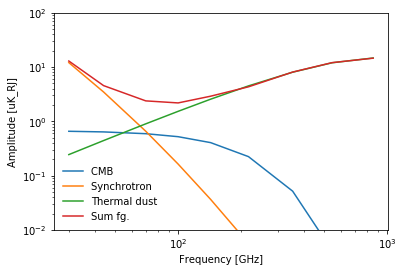

In [3]:
# Plot cmb, synchrotron, dust and total signal
def plot_func(cmb_values, synch_values, dust_values, data_values, linestyle="-", tag=""):
    plt.plot(freq.T, cmb_values, label = "CMB "+tag, linestyle=linestyle, color="C0",)
    plt.plot(freq.T, synch_values, label = "Synchrotron "+tag, linestyle=linestyle,color="C1",)
    plt.plot(freq.T, dust_values, label = "Thermal dust "+tag, linestyle=linestyle,color="C2",)
    plt.plot(freq.T, data_values, label = "Sum fg. "+tag, linestyle=linestyle,color="C3",)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Amplitude [uK_RJ]")
    plt.ylim(1e-2,1e2)
    plt.legend(loc="best", frameon=False)

plot_func(cmb, synch, dust, data)
#Data points for task 1.2:
#plt.plot(freq, [12.2, 9.0, 5.4, 4.5, 4.7, 4.8, 8.2, 13.1, 19.3], 'kx')
plt.show()

## Tasks 1
1. Play around changing the parameters in the model, the pixel size and the reference frequency and get an understanding on what changing each parameter does to the full sky model. 
2. Comment in the data points for task 1.2. Change the parameters so that the total signal (red curve) in the plot above matches these data points marked in the plot. 

# 2: MCMC sampling

We will now use the above "data" array as our simulated sky for one sky pixel. This data includes cmb, foregrounds and noise. The next step is trying to fit our sky model to our data. Since we know what the input was, we already know what the true answer should be. Thus we can use this knowledge to judge wether our sampler is able to reproduce out input. 

First we will use Markov chain Monte Carlo (MCMC) sampling, please have a look look at for instance [this blog on MCMC sampling for dummies](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) or other sources if you are unfamiliar with this method. 

For initializing the sampler, we set the number of samples we want and how long the burn-in period is. The burn in period os how many samples we leave out from the beginning of the sampling chain before the sampling has stabilized. We leave these first samples out when generating the probability distribution for the parameter values. We also set a starting point for our parameter values, this is our best guess for the value. In real life we do not know the true sky model but we have estimations from previous experiments. The step size for each parameter are also set. 

In [4]:
it = 100000           # number of samples in a chain
burn = 1000          # period of burn in
nr_values = 7       # number of parameters to sample

samples    = np.empty([it, nr_values])  # Array for storing samples
teta_start = np.empty([nr_values])      # Array for current sample
steps      = np.empty([nr_values])      # Array for step sizes

# Set _starting_ value for each parameter, this is our "best guess" of the value
teta_start[0] = .5 #.67      # CMB amplitude
teta_start[1] = 8 #12.0     # Synchrotron amplitude
teta_start[2] = -3.0 #-3.1     # Synchrotron beta (spectral index)
teta_start[3] = 0 #-0.39    # Synchrotron curvature
teta_start[4] = 10 #8.0      # Dust amplitude
teta_start[5] = 1.7 #1.6      # Dust beta (spectral index)
teta_start[6] = 20 #18.5     # Dust temperature

# Set step size for each parameter. Set to zero to keep a parameter fixed to the starting value. 
steps[0] = 0.05    # CMB amplitude
steps[1] = 0.1     # Synchrotron amplitude
steps[2] = 0.04    # Synchrotron beta (spectral index)
steps[3] = 0.04    # Synchrotron curvature
steps[4] = 0.5     # Dust amplitude
steps[5] = 0.05     # Dust beta (spectral index)
steps[6] = 0.8    # Dust temperature

## Priors
In bayesian statistics we use our prior knowledge about our parameters. Here we only include flat priors, but more advanced priors can of course be implemented, and is implementet in Commander3. Examples are gaussian priors or Jeffreys prior. For our three amplitudes, we discard negative values to ensure positive amplitudes. For dust temperature and the betas we use our knowledge from prior experiments to set allowed intervals. These should not be too small intervals. 

In [5]:
#Flat prior to exclude too extreme values and negative amplitudes
def flat_prior(tet):
    test = 0.
    if tet[0] < 0 or tet[1]<0 or tet[4]<0: # Ensure positive amplitudes
        test = -float("inf")
    if tet[2] < -4.2 or tet[2] > -2.0:   # synch Beta
        test = -float("inf")
    if tet[3] < -1.0 or tet[3] > 0.5:
        test = -float("inf")
    if tet[5] < 0.5 or tet[5] > 3.5:     # dust beta
        test = -float("inf")
    if tet[6] < 1.0 or tet[6] > 30.:    # dust temp
        test = -float("inf")
    return test

## Sampling

In [6]:
step_matrix = np.diag(steps)
teta0 = teta_start.copy()
teta  = teta_start.copy()
n = 0.              # for calculating acceptance rate    

#calculates probability that teta is the correct values for our model, 
#given the simulated data for each frequency and our foreground model
#Normal distribution
def prob(tet, dat, sig, fr, frs, frd):
    P = 0.
    for i in range(np.size(dat)): # Loop over frequencies)
        uc = unit_conv(fr[i])   # unit convertion
        cm = float(tet[0]*uc)  # cmb
        s = synch_spec(tet[1], tet[2], tet[3], fr[i], frs) #synchotron
        d = dust_spec(tet[4], tet[5], tet[6], fr[i], frd) #dust
        t = float(cm + s + d)
        P = P-((dat[i]-t)/sig[i])**2
    return P/2.

#probability for starting values:
old_prob = prob(teta, data, sigma, freq, synch_ref, dust_ref) + flat_prior(teta) 

for i in range(it):
    teta = teta + np.dot(np.random.randn(nr_values),step_matrix) #suggest new values
    prop_prob = prob(teta, data, sigma, freq, synch_ref, dust_ref) + flat_prior(teta) #probability for new teta
    #Calculate difference in probability for old and new values.
    A = min(1., np.exp(prop_prob - old_prob))
    #Always accept more probable values, sometimes accept worse vcalues
    if A >= np.random.uniform(0,1):
        teta0 = teta.copy()
        old_prob = prop_prob
        n += 1
    else: 
        teta = teta0.copy()
    samples[i, :] = teta

#New array without the first values, before burn in
samples_burn = samples[burn:, :]

print ("Accenptance rate: ", n/it)

print ("Parameter", " | ", "std ", " | ", "Average", " | ", "True value")
for i in range(nr_values):
    print ('{:>9}'.format(names[i]), " | ", format(np.std(samples_burn[:,i]), '.2f'), " | ", format(np.average(samples_burn[:,i]), '.2f'), " | ", param_in[i])

Accenptance rate:  0.0173
Parameter  |  std   |  Average  |  True value
     Acmb  |  0.26  |  0.70  |  0.67
       As  |  0.24  |  11.98  |  12.0
    Betas  |  0.17  |  -3.28  |  -3.1
   Csynch  |  0.24  |  0.20  |  -0.39
       Ad  |  0.08  |  7.93  |  8.0
    Betad  |  0.09  |  1.74  |  1.6
    Tdust  |  1.28  |  16.60  |  18.5


## Plotting sampling timeline
In an ideal world, the sampler will converge to a value and explore the parameter space around that value.
- If the timelines have long plataues (several samples with the same value): the step size is too long for one of the parameters.
- If the timeline looks very random with no values seeming to be prefered: the step size is too small. 

The acceptance rate printed above is also an idication on our choices for step sizes. This number should idealy be around 50% for a 1 parameter model, but less for a 7 parameter model.

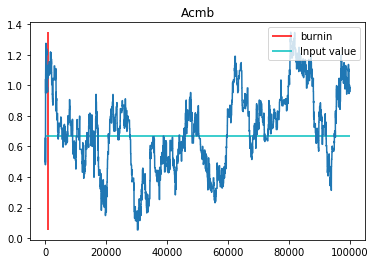

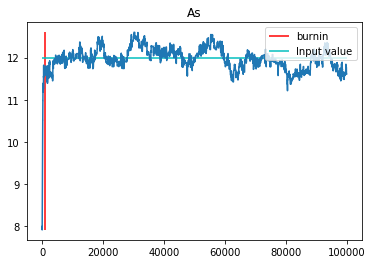

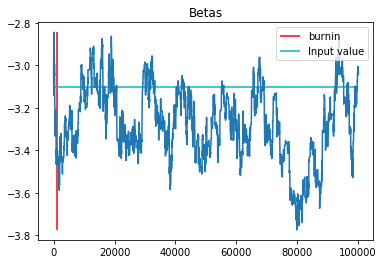

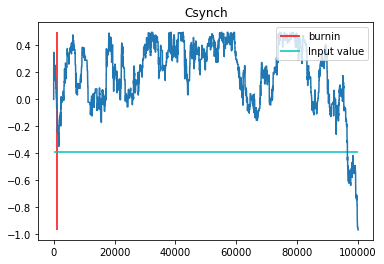

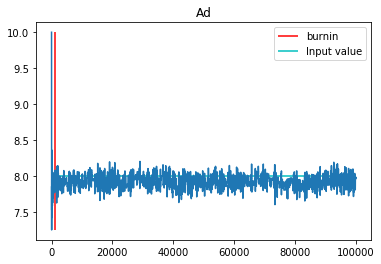

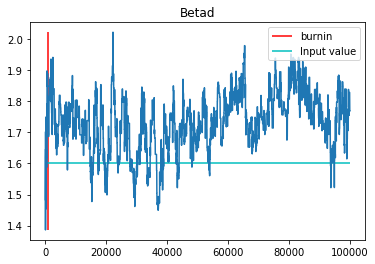

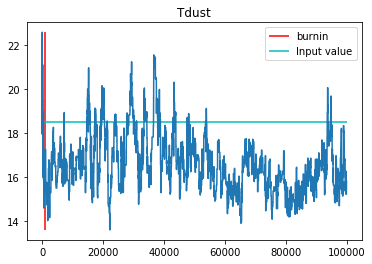

In [7]:
for i in range(np.size(names)):
    plt.plot(samples[:,i])
    plt.title(names[i])
    plt.vlines(burn, samples[:,i].min(), samples[:,i].max(), label= "burnin", colors="r")
    plt.hlines(param_in[i],0, it, label = "Input value", colors = "c")
    plt.legend(loc="upper right")
    plt.show()

## Plotting histogram for all samples 

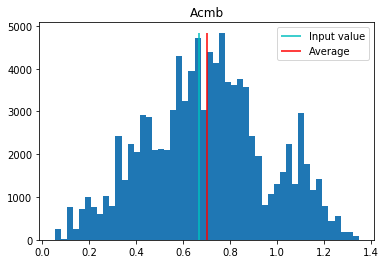

 - - - - - - - - - - - - - 


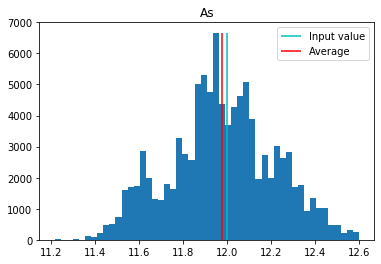

 - - - - - - - - - - - - - 


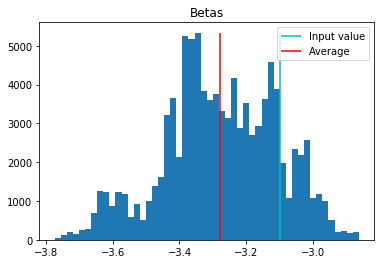

 - - - - - - - - - - - - - 


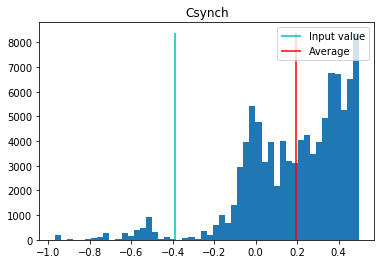

 - - - - - - - - - - - - - 


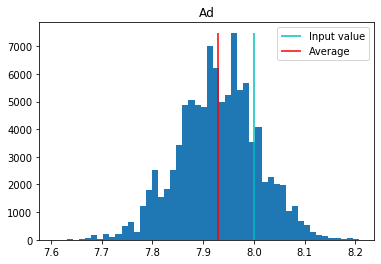

 - - - - - - - - - - - - - 


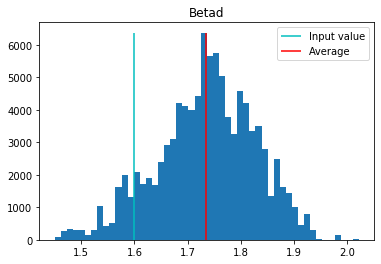

 - - - - - - - - - - - - - 


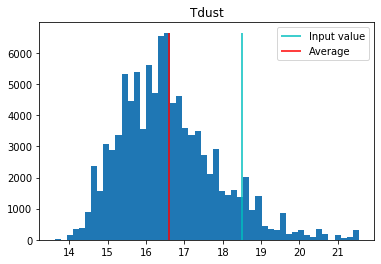

 - - - - - - - - - - - - - 


<Figure size 432x288 with 0 Axes>

In [8]:
for i in range(np.size(names)):
    y, x, _ = plt.hist(samples_burn[:,i], bins=min(50, int(np.sqrt(it))))
    plt.vlines(param_in[i], 0, y.max(), label = "Input value", colors = "c")
    plt.vlines(np.average(samples_burn[:,i]), 0, y.max(), label="Average", colors="r")
    plt.title(names[i])
    plt.legend(loc="upper right")
    plt.show()
    print (" - - - - - - - - - - - - - ")
    plt.clf()

## Plotting model based on samples

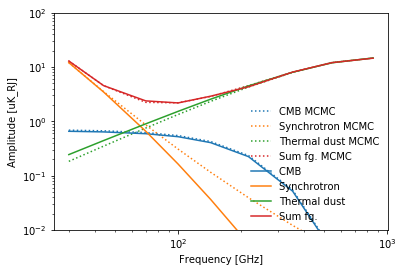

In [9]:
cmb_bf   = np.empty(np.size(freq)) 
synch_bf = np.empty(np.size(freq))
dust_bf  = np.empty(np.size(freq))
for i in range(np.size(freq)):
    # Make CMB data set
    cmb_bf[i] = np.average(samples_burn[:,0])*unit_conv(freq[i])
    # Synchrotron data
    synch_bf[i] = synch_spec(np.average(samples_burn[:,1]), np.average(samples_burn[:,2]), np.average(samples_burn[:,3]), freq[i], synch_ref)
    # Dust data
    dust_bf[i] = dust_spec(np.average(samples_burn[:,4]), np.average(samples_burn[:,5]), np.average(samples_burn[:,6]), freq[i], dust_ref)
plot_func(cmb_bf, synch_bf, dust_bf, cmb_bf+synch_bf+dust_bf, linestyle=":", tag="MCMC")
plot_func(cmb, synch, dust, data)
plt.show()

## Tasks 2:
1. Play around with the step sizes in "steps" to see how this changes the timeline plots.
2. Based on the timeline plots: evaluate how many samples should be left out in the beginning (burn)
3. Change the values for for instance  the nside, number of samples, starting value for sampler, flat prior limits etc. to see hoe this changes the final result 

# 3: Gibbs sampler
Now that we have familiarized ourselves with the MCMC sampler, we move on to the main course; the Gibbs sampler.
## Method
The idea of the gibbs sampler is that instead of sampling the full complicated distribution that describes the data for all the varying parameters (the "poseterior"), we split them up into "conditionals" and sample one parameter, while keeping all the other ones fixed. 

For this example, we have reduced our sky model to only CMB and thermal dust for speed. This means that we sample 4 free parameters; CMB amplitude (A_cmb), dust amplitude (A_d), dust beta (beta) and dust temperature (T). For a Gibbs sampler, we therefore want to sample A_cmb first, by drawing from its conditional, while assuming the previous values of A_d, beta and T. For the next step, we do the same for A_d, and assume the A_cmb we just calculated, and the previous values of beta and T. This can be written as:

\begin{aligned}
x_{1}^{(i+1)} & \sim p\left(x_{1} \mid x_{2}^{(i)}, x_{3}^{(i)}, \ldots, x_{D}^{(i)}\right) \\
x_{2}^{(i+1)} & \sim p\left(x_{2} \mid x_{1}^{(i+1)}, x_{3}^{(i)}, \ldots, x_{D}^{(i)}\right)\\
x_{j}^{(i+1)} & \sim p\left(x_{j} \mid x_{1}^{(i+1)}, x_{2}^{(i+1)}, \ldots, x_{j-1}^{(i+1)}, x_{j+1}^{(i)}, \ldots, x_{D}^{(i)}\right).
\end{aligned}

But what are these conditionals?
Which distribution we want to draw from is dependent on the type of parameter we are looking at and how it relates to our data. For the amplitude parameters, with a linear relationship to the data, we can sample from a multivariate gaussian.

### Sampling a multivariate gaussian
We may write $d = Ta+n = f(\omega)\cdot A + n$ where $\omega$ is the set of spectral indices (such as beta or T for dust).
If we rewrite this and assume that the noise is gaussian $n = d - Ta$ we can express the distribution as
\begin{align}
P(a\mid d, \omega\setminus a) &\propto P(d\mid\omega)P(a)\\
  &\propto P(d\mid a)P(a)\\
  &\propto \left[\prod_{\nu} \exp\left(-\frac{1}{2}(d_{\nu}-T_{\nu}a)^t N_{\nu}^{-1}(d_{\nu}-T_{\nu}a)\right)\right]\cdot P(a)
\end{align}
which can be sampled by solving for $a$ in 
$$\biggl(S^{-1} + \sum_{\nu}T^t_{\nu}N_{\nu}^{-1}T_{\nu}\biggr)\,a = \sum_\nu T_{\nu}^t N_\nu^{-1}d_{\nu}+\sum_\nu T_{\nu}^t N_\nu^{-1/2}m_{\nu} + \sum_{\nu}T_{\nu}^tN_{\nu}^{-1/2}\eta_{\nu} + S^{-1/2}\eta_{0},$$
where S is a prior standarad deviation, N is the noise, m is the prior mean, and $\eta$ are random normal values. For a full explanation on this, look at BeyondPlanck 1, appendix 2.


### Inversion sampling
Now that we have sampled the two amplitude parameters, we want to sample beta and T. These two parameters do not depend linearly on the data d, and are not Gaussian distributions, hence demand a different approach. 
To sample these two conditional distributions, we employ the "inversion sampler", which is completely general and works for all univariate distributions.
In our case, we have the distribution
\begin{align}
  P(\beta\mid d, a) &\propto P(d\mid a, \beta) P(\beta)\\
  &\propto \left[\prod_{\nu}
    \mathrm \exp\left(-\frac{1}{2}\left(d_{\nu}-T(\beta)a\right)^t N_{\nu}^{-1}\left(d_{\nu}-T(\beta)a\right)\right)\right]P(\beta).
\end{align}

Using this for P(x) we can sample using the inversion sampler by:
1. Compute $P(x)$ over a grid in $x$, making sure to probe the tails to sufficient accuracy.
2. Compute the cumulative probability distribution, ${F(x) = \int_{-\infty}^{x} P(x')\,\mathrm dx'}$.
3. Draw a random uniform variate, $\eta \sim U[0,1]$.
4. Solve the nonlinear equation $\eta = F(x)$ for $x$.

## Code
A seasoned programmer may look at this code and immediately see that its complete trash.
Fortunately, a cosmologist will see that it does what is needed to get the results.

The first part you will run here defines the class structure, within which all the models and functions are defined. First, it sets all the parameters, and has both the amplitude and spectral index sampler defined within it. Lastly, the Gibbs function can be called to loop over the sampling steps given a parameterfile with priors and initial values, and some set of simulated pixels. Try it, and watch in awe as nothing happens. See you in the next step.


In [3]:
import sys
import os
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as stats
from scipy.interpolate import interp1d
import corner
from tqdm import tqdm
class sky_model:
    np.random.seed(42069)
    """
    This model is a sky signal using two sky components. It has four free
    parameters. The CMB component has an amplitude A_cmb.
    And the thermal dust component had an amplitude A_d relative to the
    reference frequency nu_0, a spectral index beta which determines the 
    slope of the distribution, and the temperature T spectral index, 
    which determines the peak of the spectrum.
    """
    def __init__(self,nus,A_cmb,A_d,beta,T):
        # These parameters represent the true simulated sky
        self.nus   = nus                 # Frequencies
        self.A_d   = A_d                 # Amplitude in muK
        self.A_cmb = A_cmb               # Amplitude in muK
        self.beta  = beta                # Dust spectral index
        self.T     = T                   # Dust spectral index in muK
        self.nu_0  = 857.                # GHz er en fiksert referanse-frekvens
        self.h     = 6.62607e-34         # Planck's comstant
        self.k_b   = 1.38065e-23         # Boltzmanns constant
        self.Tcmb  = 2.7255              # K CMB Temperature
        self.K     = self.h*1e9/self.k_b # Constant

    def s_nu(self, nu):
        # Total signal as a function of frequency
        return self.s_d(nu)+self.s_cmb(nu)

    def s_d(self,nu): 
        # Thermal dust modified blackbody
        return self.A_d*(nu/self.nu_0)**(self.beta+1)*(np.exp(self.K*self.nu_0/self.T) - 1.)/(np.exp(self.K*nu/self.T) - 1.)

    def s_cmb(self,nu): 
        # CMB blackbody
        return self.A_cmb/self.g(nu)

    def g(self,nu): 
        # Conversion factor between thermodynamic and brightness temperature
        x = self.K*nu/self.Tcmb
        return (np.exp(x)-1)**2 / (x**2 * np.exp(x))

    def d_nu(self,nu): 
        # Function for adding noise to the signal
        s = self.s_nu(nu)
        self.sigma = 0.1*s
        return s + np.random.randn(len(nu))*self.sigma

    def gauss(self,var,d,p):
        """
        This is the amplitude sampler
        """
        mean_prior, sigma_prior = p
        if var=="A_d":
            T = self.s_d(self.nus)/getattr(self, var)
            d_ = d-self.s_cmb(self.nus)
        elif var=="A_cmb":
            T = self.s_cmb(self.nus)/getattr(self, var)
            d_ = d-self.s_d(self.nus)

        a1 = sum(d_*T/self.sigma**2)+sum(T/self.sigma*np.random.randn(len(T)))\
                +np.random.normal()/sigma_prior+mean_prior/sigma_prior**2
        a2 = sum((T/self.sigma)**2)+sigma_prior**-2
        setattr(self,var,a1/a2)

    def inverse(self, xs, com, d,p):
        """
        This is an inversion sampler for sampling spectral indices
        """
        mean_prior, sigma_prior = p
        P = np.zeros(1000)
        setattr(self,com,xs) # assign range of values
        for i, nu in enumerate(self.nus):
            s = self.s_nu(nu)
            P += (d[i]-s)**2/(2*(self.sigma[i])**2)
        
        P += (xs - mean_prior)**2 / (2 * sigma_prior**2)
        Px = np.exp(-P+np.min(P))
        dx = abs(xs[1]-xs[0])
        Fx = np.cumsum(Px*dx)
        eta = np.random.uniform(0,max(Fx))
        c1 = min(xs); c2 = max(xs)
        f = interp1d(Fx, xs, bounds_error=False, fill_value=(c1,c2))
        x = f(eta)
        if x < c1: x=c1
        elif x > c2: x=c2
        # Update value
        setattr(self,com,x)

    def gibbs(self, d, params):
        for label, comp in params["comps"].items():
            for par, val in comp.items():
                # Set init value of parameter
                setattr(self, par, val["init"]) 

        n = params["ngibbs"]
        burnin = int(n/4) # When to start saving
        thetas = np.zeros((n-burnin,4)) # Saving data
        
        # Ranges for inverse sampling
        xbeta = np.linspace(1.0,3.0,1000)
        xT = np.linspace(10.,30.,1000)
        for i in tqdm(range(n), desc="Gibbs sampling"): # Gibbs samples

            """ Sampling A_dust """
            self.gauss("A_d",d,params["comps"]["dust"]["A_d"]["prior"])

            """ Sampling A_cmb """
            self.gauss("A_cmb",d,params["comps"]["cmb"]["A_cmb"]["prior"])

            """ Sampling Beta """
            self.inverse(xbeta, "beta", d, params["comps"]["dust"]["beta"]["prior"])

            """ Sampling T """
            self.inverse(xT, "T",d,params["comps"]["dust"]["T"]["prior"])

            if i >= burnin: thetas[i-burnin,:] = (self.A_d, self.A_cmb, self.beta, self.T)
        return thetas
    


## Make simulated pixels on the sky for a chosen set of frequency bands
Good job. The next part is to simulate the sky for a set of frequency bands. 
I have chosen the planck frequency bands with an additional data point at 2500 GHz.
Next, we set the parameters for the "true" sky in the simulated data and get our set of simulated pixels by calling the "d_nu" function, which calculates the corresponding sky signal, and adds a bit of noise.

In [11]:
# Simulated dataset of frequency bands
nus = np.array([30,44,70,100,143,217,353,545,857]) #GHz
#nus = np.logspace(np.log10(10),np.log10(2500),50) #GHz

# Initialize sky model with "True" parameters
model = sky_model(nus, A_cmb=67, A_d=100, beta=1.6, T=19)   
pixels = model.d_nu(nus) # Get simulated data pixels

## Run the Gibbs sampler
This is where the fun begins. Now that we have simulated the sky again, we can run our Gibbs sampler to try to figure out what the underlying parameters are.
The "params" dictionary, here, contains a few useful paramaters. For each of the four components, we set a few values.

First, an initial value, which is some dumb, wrong starting point, to make sure we didn't just get lucky with our initial guess. 
 
Next, we set the prior mean and standard deviation. The "prior_scaling" variable is there to be able to quickly turn off the prior on all components, by setting it to some super large value and making the prior very wide. It can also be set to be really small, and thereby constraining the fit even more.

All the way at the top, we can also set the number of Gibbs samples that we want to run.

Try to run it and see the corner-plot output.


Gibbs sampling: 100%|██████████| 2000/2000 [00:03<00:00, 515.57it/s]
Plotting


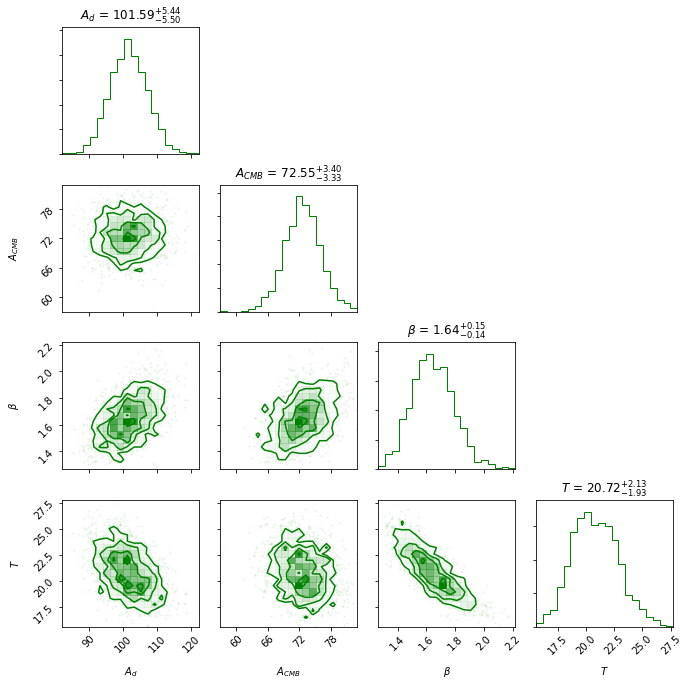

In [13]:
prior_scaling=1
params = {
    "ngibbs": 2000,
    "comps":{
        "cmb": {
            "A_cmb": {
                "init": 100,
                "prior": (70, 10*prior_scaling),
            }
        },
        "dust": {
            "A_d": {
                "init": 50,
                "prior": (110, 20*prior_scaling),
            },
            "beta": {
                "init": 1.8,
                "prior": (1.65, .3*prior_scaling),
            },
            "T": {
                "init": 20,
                "prior": (18., 3*prior_scaling),
            }
        }
    }
}
thetas = model.gibbs(pixels, params) # Start gibbs sampling with these init values

print("Plotting")
fig = corner.corner(thetas,color='g', labels=[r"$A_d$",r"$A_{CMB}$", r"$\beta$", r"$T$"], show_titles=True, title_kwargs={"fontsize": 12})
plt.tight_layout()
plt.show()

### Tasks
1. Change the prior standard-deviation, and see how it influences the system.
2. Remove the high frequency bands and see how it influences the determination of T
3. Change the number of frequency bands and see if you can get better constraints with more data.

While doing this, you can also run the script underneath here, which plots the sky as described by your sampled values, and the true sky.


### Plot Sampled sky model

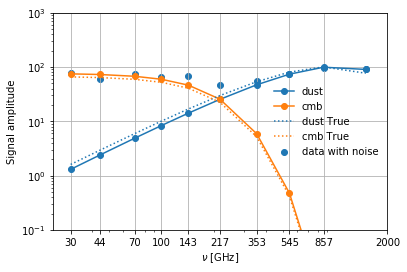

In [15]:

plt.loglog(nus,model.s_d(nus),"-o", color="C0", label="dust")
plt.loglog(nus,model.s_cmb(nus),"-o",color="C1", label="cmb")
model = sky_model(nus,A_cmb=67, A_d=100, beta=1.6, T=19)      # Initialize sky model
plt.loglog(nus,model.s_d(nus),color="C0", linestyle=":", label="dust True")
plt.loglog(nus,model.s_cmb(nus),color="C1", linestyle=":", label="cmb True")
plt.scatter(nus,pixels, color="C2", label="data with noise")
plt.legend(frameon=False)
nus_ = np.array([30,44,70,100,143,217,353,545,857,2000]) #GHz
plt.xticks(nus_,nus_)
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('Signal amplitude')
plt.ylim(1e-1,1e3)

plt.grid()
plt.show()